In [1]:
using Parameters, Plots

# PS1 - Solution

Now we will modify the program in `02Growth_model.jl` so it can be used for a stocastic version of the model.

We start by defining the stochastic process that governs the change in technology.

Suppose that technology shocks follow a 2 state Markov process with possible values in the set $\zeta = \{z^g=1.25,z^b=0.2\}$ and transition matrix:

$$\begin{pmatrix}0.977 & 0.023\\0.074 & 0.926\end{pmatrix}$$

## 1. Dynamic Programming Problem

The agents solve the following maximization problem:

$$\begin{aligned}\max_{c_t, k_{t+1}}&\quad \sum_{t=0}^{\infty} \ln{(c_t)}\\ s.t.& \quad c_t + k_{t+1} \leq z_t k_t^\alpha + (1-\delta) k_t  \end{aligned}$$

We can solve this problem using using Dynamic Programming:

$$v(k, z) = \max_{c, k' \in \Gamma(k)} \left\{\log(c) + \beta \mathbb{E}[v(k', z')\mid z]\right\}$$

Since the stochastic process is a Finite State Markov Chain we can simplfy the problem to:

$$v(k, z) = \max_{c, k' \in \Gamma(k)} \left\{\log(c) + \beta [v(k', z^g)p_{gi} + v(k', z^b)p_{bi}]\right\}$$

where $p_{gi}$ and $p_{bi}$ are the probabilities of transitioning from state $z^i$ to state $z^g$ and $z^b$.

Since the utility function is increasing then we can assume $$c = z k^\alpha + (1-\delta) k  - k'$$

Consider:

$$
\mathbf{V}(k)=\left(V\left(k, z^{g}\right), V\left(k, z^{b}\right)\right)
$$

in the space $\mathcal{C}_{2}(\mathbb{R}_+)$ of vectors of real valued functions, which are continuous and bounded in $\mathbb{R}_+$.

Next, define the operator $T:\mathcal{C}_{2}(\mathbb{R}_+) \to \mathcal{C}_{2}(\mathbb{R}_+)$:

$$T \mathbf{V}(k)=\left\{\begin{array}{l}
\max_{c, k' \in \Gamma(k,z^g)} \left\{\log(c) + \beta [v(k', z^g)p_{gg} + v(k', z^b)p_{bg}]\right\}\\
\max_{c, k' \in \Gamma(k, z^b)} \left\{\log(c) + \beta [v(k', z^g)p_{gb} + v(k', z^b)p_{bb}]\right\}
\end{array}\right.$$

We have moved from an stochastic problem to a deterministic one.

Here I will coment the changes tahat I made to the code.

In [2]:
@with_kw struct Primitives
    β::Float64 = 0.99 #discount rate
    δ::Float64 = 0.025 #depreciation rate
    α::Float64 = 0.36 #capital share
    k_min::Float64 = 0.01 #capital lower bound
    k_max::Float64 = 75.0 #capital upper bound
    nk::Int64 = 1000 #number of capital grid points
    k_grid::Array{Float64,1} = collect(range(k_min, length = nk, stop = k_max)) #capital grid
    # The parameters are added to model the stocastic technology shocks
    z_vals::Array{Float64,2} = [1.25 0.2] #values of technology shocks
    nz::Int64 = 2 #number of technology shocks
    Π::Array{Float64,2} = [0.977  0.023; 0.074  0.926]; #transition matrix
end

#structure that holds model results
mutable struct Results
    # I will include savings as a result for easier access
    # All arrays are now two dimensional to allow for the technology shock
    val_func::Array{Float64, 2} #value function
    pol_func::Array{Float64, 2} #policy function
    savings::Array{Float64, 2} #savings
end

#function for initializing model primitives and results
function Initialize()
    prim = Primitives() #initialize primtiives
    val_func = zeros(prim.nk, prim.nz) #initial value function guess
    pol_func = zeros(prim.nk, prim.nz) #initial policy function guess
    savings = zeros(prim.nk, prim.nz) #initial savings
    res = Results(val_func, pol_func, savings) #initialize results struct
    prim, res #return deliverables
end

Initialize (generic function with 1 method)

In [3]:
prim, res = Initialize();

### Bellman Equation

Next we will modify the Bellman equation to include the stochastic process. I made the following changes:

* I added an outermost loop that iterates over the possible values of technology.
* Now the pair $(k,z)$ are state variables, therefore the rsults will be two dimensional vectors.
* I inlcuded `z` in the compuatation of the budget set.

**Note:** Since the feasible correspondance is non-empty, compact valued and monotonic and the utility function is contious and bounded in the feasible region and increasing in the initial capital level we can assure that the value function is increasing.

* This means that once we have the we only have to test next period capital levels that are greater than or equal the current period capital level. And this holds for any value of the stochastic process.

In [4]:
function Bellman_stocastic_finite_state(prim::Primitives,res::Results)
    @unpack val_func = res #unpack value function
    @unpack k_grid, β, δ, α, nk, z_vals, Π, nz = prim #unpack model primitives
    v_next = zeros(nk, nz) #next guess of value function to fill
    choice_lower = 1 #for exploiting monotonicity of policy function
    
    # NEW (1): First we iterate over all possible values of z
    for z_index = 1:nz
        z = z_vals[z_index] #current value of z
        for k_index = 1:nk
            k = k_grid[k_index] #value of k
            candidate_max = -Inf #bad candidate max
            budget = z*k^α + (1-δ)*k #budget
            for kp_index in choice_lower:nk #loop over possible selections of k', exploiting monotonicity of policy function
                c = budget - k_grid[kp_index] #consumption given k' selection
                if c > 0 #check for positivity
                    # NEW (2): We now use the expected value of the next period's value function
                    val = log(c) + β*(val_func[kp_index, :]' * Π[z_index, :])  #compute value
                    if val > candidate_max #check for new max value
                        candidate_max = val #update max value
                        res.pol_func[k_index, z_index] = k_grid[kp_index] #update policy function
                        choice_lower = kp_index #update lowest possible choice
                    end #if val > candidate_max
                end #if c > 0
            end #end loop over k'
            v_next[k_index, z_index] = candidate_max #update value function
        end # end of loop over k
    end #end of z loop
    v_next #return next guess of value function
end

Bellman_stocastic_finite_state (generic function with 1 method)

## Solving the Model

In [39]:
#Value function iteration
function V_iterate(prim::Primitives, res::Results; tol::Float64 = 1e-4, err::Float64 = 100.0)
    n = 0 #counter

    while err>tol #begin iteration
        v_next = Bellman_stocastic_finite_state(prim, res) #spit out new vectors
        err = abs.(maximum(v_next.-res.val_func))/abs(v_next[prim.nk, 1]) #reset error level
        res.val_func = v_next #update value function
        n+=1
    end
    println("Value function converged in ", n, " iterations.")
end 

V_iterate (generic function with 1 method)

In [74]:
[res.val_func[k, :]' * Π[1, :] for k in 1: prim.nk]

1000-element Vector{Float64}:
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
   ⋮
  10.104153019151976
  10.106953964346552
  10.109752212588056
  10.112548831411843
  10.115341598277855
  10.118130343176883
  10.12091749851657
  10.1237022929671
  10.126481448230095
  10.129259417870879
  10.132036074772262
  10.134806001203465

In [5]:
v_next = Bellman_stocastic_finite_state(prim, res)

sum(v_next .> 0 )

1984

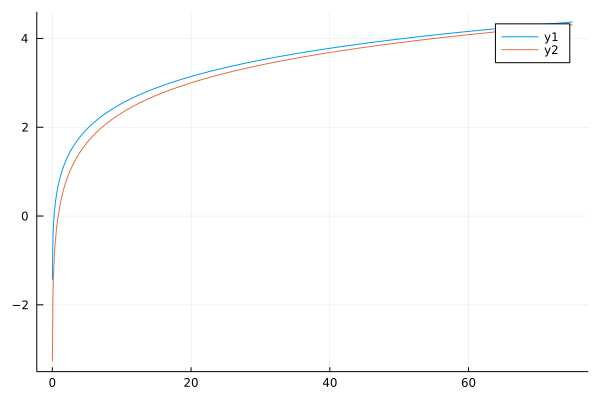

In [6]:
plot(prim.k_grid, v_next)

In [40]:
V_iterate(prim, res)

Value function converged in 3 iterations.


In [47]:
prim.Π[1,:]' * prim.z_vals' #transition matrix

1×1 adjoint(::Vector{Float64}) with eltype Float64:
 1.2258499999999999

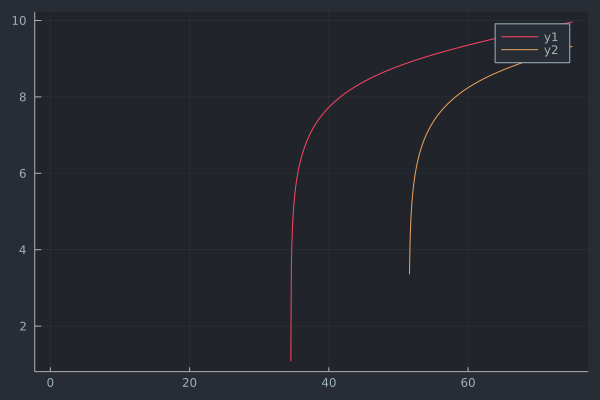

In [43]:
theme(:juno)
plot(prim.k_grid, res.val_func)